In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse

import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Compose
import matplotlib.pyplot as plt
import os
import os
import pickle

In [38]:
train_dataset = datasets.CIFAR10(root='data/', download=True, train=True, transform=ToTensor())
test_dataset = datasets.CIFAR10(root='data/', download=True, train=False, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [39]:
def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f,encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
    return X, Y
def load_CIFAR10():
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join('data', 'cifar-10-batches-py', 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join('data', 'cifar-10-batches-py', 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [78]:
X_train, y_train, X_test, y_test = load_CIFAR10()

In [79]:
X_train = X_train[0:50000]
y_train = y_train[0:50000]
X_test = X_test[0:10000]
y_test = y_test[0:10000]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [80]:
X_train = X_train.reshape(50000,3072)
X_test = X_test.reshape(10000,3072)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 3072)
(50000,)
(10000, 3072)
(10000,)


In [153]:
class Softmax:
    
    def fit(self,X_train,y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def getLoss(self,w,x,y,lam):
        m = x.shape[0] 
        y_mat = self.oneHot(y) 
        scores = np.dot(x,w) 
        prob = self.softmax(scores) 
        result = np.where(prob > 0.0000000001, prob, -10)
        loss = (-1 / m) * np.sum(y_mat * np.log(result, out=result, where=result > 0)) + (lam/2)*np.sum(w*w) 
        grad = (-1 / m) * np.dot(x.T,(y_mat - prob)) + lam*w 
        return loss,grad
    
    def oneHot(self,Y):
        m = Y.shape[0]

        OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
        OHX = np.array(OHX.todense()).T
        return OHX
    
    def softmax(self,z):
        z -= np.max(z)
        sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
        return sm

    def predict(self,X_test):
        prob = self.softmax(np.dot(X_test,self.w))
        pred = np.argmax(prob,axis=1)
        return prob,pred
    
    def Accuracy(self,X_test,Y_test):
        prob,pred = self.predict(X_test)
        accuracy = sum(pred == Y_test)/(float(len(Y_test)))
        return accuracy
    
    def Train(self,w,lam,iters,lr):
        self.w = w
        self.lam = lam
        self.iterations = iters
        self.learningRate = lr
        losses = []
        for i in range(0,self.iterations):
            loss,grad = self.getLoss(self.w,self.X_train,self.y_train,self.lam)
            losses.append(loss)
            
            self.w = self.w - (self.learningRate * grad)
        return losses

In [154]:
clf = Softmax()

In [155]:
clf.fit(X_train,y_train)

In [156]:
w = np.zeros([X_train.shape[1],len(np.unique(y_train))])
losses = clf.Train(w,1,3000,0.00000036)
a_axis = [i for i in range(1,3001)]

In [157]:
clf.Accuracy(X_test,y_test)

0.4049

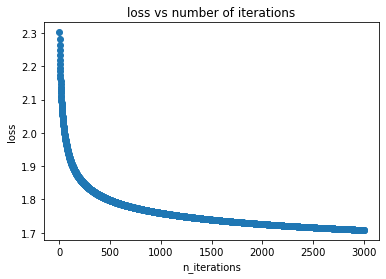

In [159]:
fig, ax = plt.subplots()
ax.set_xlabel("n_iterations")
ax.set_ylabel("loss")
ax.set_title("loss vs number of iterations")
ax.plot(a_axis, losses, marker="o", drawstyle="steps-post")

plt.show()